In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_scheduler
from accelerate import Accelerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def get_device():
  device="cpu"
  if torch.cuda.is_available():
    device="cuda"
  elif  torch.backends.mps.is_available():
    device='mps'
  else:
    device="cpu"
  return device

device = get_device()
print(device) 

mps


In [4]:
dataset = pd.read_csv("Tweets.csv")
dataset = dataset.filter(["text", "airline_sentiment"])
print("==============================================")
print(f'The shape of the dataset is: {dataset.shape}')
print("==============================================")
print(f'The number of sentiments in each category is:\n{dataset.airline_sentiment.value_counts()}')
print("==============================================")
dataset.head()

The shape of the dataset is: (14640, 2)
The number of sentiments in each category is:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [5]:
sentiment_mapping = {
    'positive': 1,
    'neutral': 0,
    'negative': 2
}

dataset['airline_sentiment'] = dataset['airline_sentiment'].replace(sentiment_mapping)
df = dataset
df = df.rename(columns={'text': 'tweet', 'airline_sentiment': 'label'})
df.head()

/var/folders/4j/f9p0tjqj1ql3bytxkr213dn40000gn/T/ipykernel_46052/1047948707.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['airline_sentiment'] = dataset['airline_sentiment'].replace(sentiment_mapping)


,tweet,label
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,2
4,@VirginAmerica and it's a really big bad thing...,2


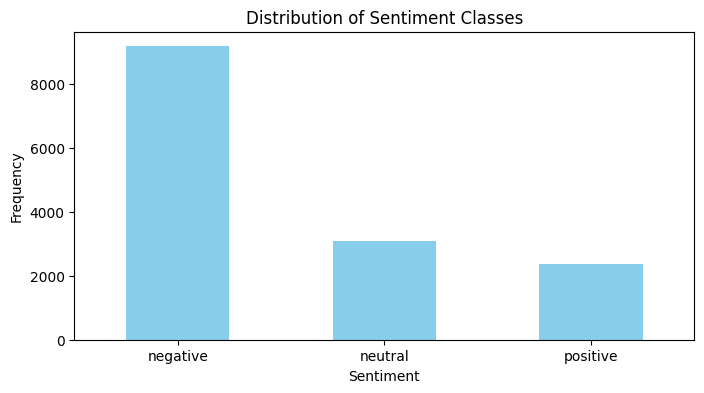

In [24]:
# Assuming 'df' is your DataFrame and 'label' is the column with numeric class labels
# Map numeric labels to textual labels
sentiment_mapping = {2: 'negative', 0: 'neutral', 1: 'positive'}
df['textual_sentiment'] = df['label'].map(sentiment_mapping)

class_counts = df['textual_sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 4))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotates the labels to be horizontal
plt.show()

In [26]:
data=list(zip(df['tweet'].tolist(), df['label'].tolist()))
texts, labels = zip(*data)

In [27]:


# Assuming 'texts' contains the text data and 'labels' contains the class labels
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.1, random_state=42, stratify=labels)  # Ensures stratified split

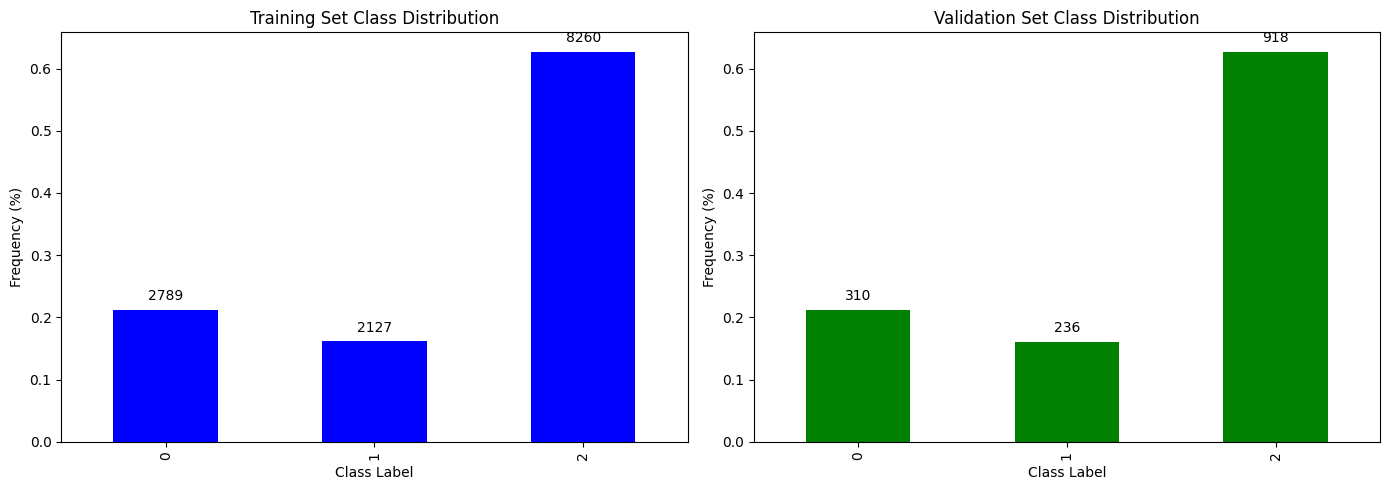

In [28]:


# Convert labels to DataFrames for easy manipulation
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
val_labels_df = pd.DataFrame(val_labels, columns=['label'])

# Get the frequency of each class
train_class_distribution = train_labels_df['label'].value_counts().sort_index()
val_class_distribution = val_labels_df['label'].value_counts().sort_index()

# Calculate normalized distribution for percentages
train_class_distribution_normalized = train_class_distribution / train_class_distribution.sum()
val_class_distribution_normalized = val_class_distribution / val_class_distribution.sum()

# Create a plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
train_class_distribution_normalized.plot(kind='bar', ax=axes[0], color='blue', title='Training Set Class Distribution')
val_class_distribution_normalized.plot(kind='bar', ax=axes[1], color='green', title='Validation Set Class Distribution')

# Adding the count above the bars
for ax, dist in zip(axes, [train_class_distribution, val_class_distribution]):
    for i, p in enumerate(ax.patches):
        count = dist.iloc[i]
        # Annotation should be adjusted based on the bar's height to avoid overlap or misplacement
        height = p.get_height()
        ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

axes[0].set_ylabel('Frequency (%)')
axes[0].set_xlabel('Class Label')
axes[1].set_ylabel('Frequency (%)')
axes[1].set_xlabel('Class Label')

plt.tight_layout()
plt.show()

In [30]:
import numpy as np
# Convert labels to a numpy array if not already
train_labels_np = np.array(train_labels)

# Count the frequency of each class
unique_classes, counts = np.unique(train_labels_np, return_counts=True)

# Calculate class weights inversely proportional to class frequencies
weights = 1.0 / counts

# Normalize weights so that the sum equals the number of classes or to sum to 1
weights = weights / weights.sum()

# Convert weights to a tensor for use with PyTorch
class_weights = torch.tensor(weights, dtype=torch.float,device=device)

print("Class weights:", class_weights)

Class weights: tensor([0.3775, 0.4950, 0.1275], device='mps:0')


Maximum length of tweets: 186


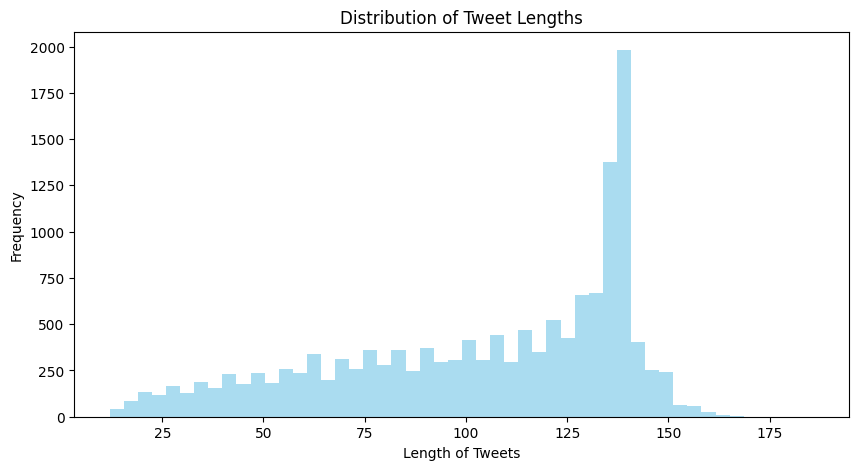

In [31]:

# Assuming you have a DataFrame df with a column 'tweet' containing the text of the tweets
df['tweet_length'] = df['tweet'].apply(len)

# Print the maximum tweet length
max_length = df['tweet_length'].max()
print("Maximum length of tweets:", max_length)

# Plot the distribution of tweet lengths
plt.figure(figsize=(10, 5))
plt.hist(df['tweet_length'], bins=50, color='skyblue', alpha=0.7)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')
plt.show()

In [32]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [34]:
# # this is just creating list of tuples. Each tupe has (text, label)
# data=list(zip(df['tweet'].tolist(), df['label'].tolist()))

def tokenize_and_encode(texts, labels, max_length=200):
    input_ids, attention_masks, labels_out = [], [], []
    for text, label in zip(texts, labels):
        encoded = tokenizer.encode_plus(
            text, 
            max_length=max_length,    # Set to 200 based on distribution analysis
            padding='max_length',     # Pads to `max_length`
            truncation=True           # Truncates to `max_length`
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels_out.append(label)
    return torch.tensor(input_ids), torch.tensor(attention_masks), torch.tensor(labels_out)

# # seprate the tuples
# # generate two lists: a) containing texts, b) containing labels
# texts, labels = zip(*data)

# # train, validation split
# train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.1)

# tokenization
train_input_ids, train_attention_masks, train_labels = tokenize_and_encode(train_texts, train_labels)
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(val_texts, val_labels)




In [35]:
print("Train input_ids shape:", train_input_ids.shape)
print("Train attention_masks shape:", train_attention_masks.shape)
print("Train labels shape:", train_labels.shape)
print("Validation input_ids shape:", val_input_ids.shape)
print("Validation attention_masks shape:", val_attention_masks.shape)
print("Validation labels shape:", val_labels.shape)


Train input_ids shape: torch.Size([13176, 200])
Train attention_masks shape: torch.Size([13176, 200])
Train labels shape: torch.Size([13176])
Validation input_ids shape: torch.Size([1464, 200])
Validation attention_masks shape: torch.Size([1464, 200])
Validation labels shape: torch.Size([1464])


In [36]:
print('train_input_ids ',train_input_ids[0].shape ,train_input_ids[0], '\n'
      'train_attention_masks ', train_attention_masks[0] ,train_attention_masks[0], '\n'
      'train_labels', train_labels[0])

train_input_ids  torch.Size([200]) tensor([  101,  1030,  3915,  4313, 14035,  5667,  1029,  1029,  1029,  2106,
         2017,  2025,  2156,  2008,  1045,  1005,  2310,  2985,  1016,  2420,
         1011,  2005,  3674,  2847,  2006,  2907,  2074,  2000,  2031,  2000,
         6865,  2039,  2044,  1996,  2847,  1029,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [37]:
class TextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels, num_classes=3):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels
        self.num_classes = num_classes
        self.one_hot_labels = self.one_hot_encode(labels, num_classes)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.one_hot_labels[idx]
        }


    @staticmethod
    def one_hot_encode(targets, num_classes):
        targets = targets.long()
        one_hot_targets = torch.zeros(targets.size(0), num_classes)
        one_hot_targets.scatter_(1, targets.unsqueeze(1), 1.0)
        return one_hot_targets
        

train_dataset = TextClassificationDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TextClassificationDataset(val_input_ids, val_attention_masks, val_labels)


In [38]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_dataloader = DataLoader(val_dataset, batch_size=8)

In [39]:
print(len(train_dataset))
len((val_dataset))

13176


1464

In [42]:
item=next(iter(train_dataloader))
item_ids,item_mask,item_labels=item['input_ids'],item['attention_mask'],item['labels']
print ('item_ids, ',item_ids.shape, '\n',
       'item_mask, ',item_mask.shape, '\n',
       'item_labels, ',item_labels.shape, '\n',)

item_ids,  torch.Size([8, 200]) 
 item_mask,  torch.Size([8, 200]) 
 item_labels,  torch.Size([8, 3]) 



In [43]:

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=5e-5)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [44]:
# Prepare the model and optimizer
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)


In [45]:
# Setup
num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
      "linear",
      optimizer=optimizer,
      num_warmup_steps=0,
      num_training_steps=num_training_steps
)

# Lists to store losses and metrics
training_losses = []
validation_losses = []



# Training and Evaluation Loop
for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    progress_bar = tqdm(total=len(train_dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')

    print("training started")

    for i,batch in enumerate(train_dataloader):
        # print("batch ", i+1)
        # print("...",end="")
        outputs = model(**batch)
        # loss = outputs.loss
        loss = loss_fn(outputs.logits, batch['labels']) 

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Collect loss data
        batch_losses.append(loss.item())
        progress_bar.update(1)

    progress_bar.close()

    # Reporting average training loss after each epoch
    epoch_training_loss = sum(batch_losses) / len(batch_losses)
    training_losses.append(epoch_training_loss)
    print(f"Training Loss after Epoch {epoch + 1}: {epoch_training_loss}")

    # Evaluation
    model.eval()
    preds = []
    out_label_ids = []
    batch_val_losses = []


    print("Validation started")

    for batch in eval_dataloader:
        with torch.no_grad():
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            logits = outputs.logits
            val_loss = loss_fn(outputs.logits, batch['labels']) 
            # val_loss = outputs.loss

            # Collect validation data
            # Convert logits to predicted class indices for comparison
            predicted_labels = torch.argmax(logits.detach().cpu(), dim=1).numpy()
            
            # Assuming batch['labels'] is one-hot encoded, convert it to class indices
            true_labels = torch.argmax(batch['labels'], dim=1).cpu().numpy()
            
            preds.extend(predicted_labels)
            out_label_ids.extend(true_labels)
            batch_val_losses.append(val_loss.item())

    # Reporting average validation loss and metrics
    epoch_validation_loss = sum(batch_val_losses) / len(batch_val_losses)
    validation_losses.append(epoch_validation_loss)

    accuracy = accuracy_score(out_label_ids, preds)
    f1 = f1_score(out_label_ids, preds, average='weighted')
    recall = recall_score(out_label_ids, preds, average='weighted')
    precision = precision_score(out_label_ids, preds, average='weighted')

    print(f"Validation Results - Epoch {epoch + 1}/{num_epochs}:")
    print(f"Validation Loss: {epoch_validation_loss}")
    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}, Precision: {precision}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
Epoch 1/2:   0%|          | 0/1647 [00:00<?, ?batch/s]TOKENIZERS_PARALLELISM=(true | false)


training started


Epoch 1/2: 100%|██████████| 1647/1647 [09:24<00:00,  2.92batch/s]


Training Loss after Epoch 1: 0.1377007141856349
Validation started
Validation Results - Epoch 1/2:
Validation Loss: 0.1096745663286884
Accuracy: 0.7903005464480874, F1 Score: 0.8005353199897579, Recall: 0.7903005464480874, Precision: 0.8424154999847375


Epoch 2/2:   0%|          | 0/1647 [00:00<?, ?batch/s]

training started


Epoch 2/2: 100%|██████████| 1647/1647 [09:19<00:00,  2.94batch/s]


Training Loss after Epoch 2: 0.07242079818978653
Validation started
Validation Results - Epoch 2/2:
Validation Loss: 0.11252041171493182
Accuracy: 0.8456284153005464, F1 Score: 0.8494870921166335, Recall: 0.8456284153005464, Precision: 0.857326367231953


In [48]:
# Using PyTorch's torch.save to save the model state_dict
torch.save(model.state_dict(), 'model_state_dict.pt')

# Alternatively, using save_pretrained from the transformers library (recommended)
model.save_pretrained('model/')  # Saves configuration file and model weights
tokenizer.save_pretrained('model/')  # Saves tokenizer config and vocabulary

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For a nicer heatmap visualization

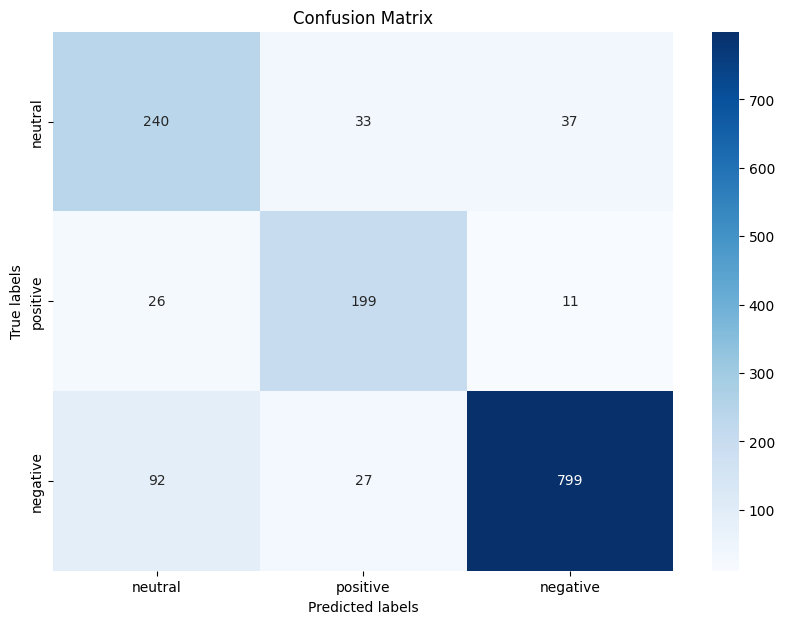

In [59]:
# Assuming out_label_ids and preds are your lists of labels and predictions
cm = confusion_matrix(out_label_ids, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['neutral', 'positive', 'negative'] , yticklabels=['neutral', 'positive', 'negative'] )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [49]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# If you saved with torch.save for state_dict
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # Ensure num_labels matches your training setup
model.load_state_dict(torch.load('model_state_dict.pt'))
model.eval()  # Set to evaluation mode

# If you used save_pretrained
model = AutoModelForSequenceClassification.from_pretrained('model/')
tokenizer = AutoTokenizer.from_pretrained('model/')

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [58]:
def predict_sentiment(text):
    # Encode the text using the provided tokenizer
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=200,  # ensure the same max_length as during training
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt',  # Return PyTorch tensors
    )
    
    # Move the tensors to the appropriate device
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    # Model in evaluation mode
    model.eval()
    
    # No need to compute gradients
    with torch.no_grad():
        # Forward pass, get logits
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Compute softmax to get probabilities from logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    # Get the predicted class index
    predicted_class = torch.argmax(probabilities, dim=1).cpu().numpy()[0]

    # Map the class index to label
    labels = ['neutral', 'positive', 'negative']  # adjusted to match your training labels
    predicted_label = labels[predicted_class]
    
    return predicted_label, probabilities.cpu().numpy()

# # Example usage:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

example_tweets = [
    "This flight was incredible, excellent service!",
    "The flight was okay.",
    "Horrible flight experience, will never fly with them again!",
    "Flight was delayed but the staff handled it well.",
    "Never had a worse flight, terrible food and rude staff!"
]

# Evaluate each tweet
for tweet in example_tweets:
    predicted_label, probabilities = predict_sentiment(tweet)
    print(f"Tweet: {tweet}\nPredicted Sentiment: {predicted_label}, Probabilities: {probabilities}\n")

Tweet: This flight was incredible, excellent service!
Predicted Sentiment: positive, Probabilities: [[0.00371296 0.99491465 0.00137239]]

Tweet: The flight was okay.
Predicted Sentiment: neutral, Probabilities: [[0.5683631  0.3891902  0.04244675]]

Tweet: Horrible flight experience, will never fly with them again!
Predicted Sentiment: negative, Probabilities: [[0.01026245 0.00273733 0.98700017]]

Tweet: Flight was delayed but the staff handled it well.
Predicted Sentiment: positive, Probabilities: [[0.01292093 0.95004636 0.03703271]]

Tweet: Never had a worse flight, terrible food and rude staff!
Predicted Sentiment: negative, Probabilities: [[0.00508581 0.00221362 0.9927005 ]]

